In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [84]:
df = pd.read_csv('../data/alle_data_sligro.csv', sep=';')

In [85]:
#make new df with only relevant columns. Omzet_Sligro, jaar, Segment, Hoofdactiviteit

df_clean = df[['Omzet_Sligro', 'jaar', 'Segment', 'Hoofdactiviteit', 'Categorie2']]

df_clean = df_clean.dropna()

# Heart en Heart RMFK samenvoegen tot 'Heart' in Categorie2
if 'Categorie2' in df_clean.columns:
    df_clean['Categorie2'] = df_clean['Categorie2'].replace({'Heart RMFK': 'Heart'})
    # Hernoem Categorie2 naar Brand
    df_clean = df_clean.rename(columns={'Categorie2': 'Brand'})

# remove rows where Segment is 'Werken', 'Zorgen', 'Not supported', 'Grossiers'
df_clean = df_clean[~df_clean['Segment'].isin(['Werken', 'Zorgen', 'Not supported', 'Grossiers'])]

In [86]:
df_clean

,Omzet_Sligro,jaar,Segment,Hoofdactiviteit,Brand
0,453,2025,Eten,Restaurant - fast casual,Heart
1,28,2025,Leisure,Speeltuin/-hal,Calippo
2,55,2023,Eten,Fast food - snacks & frites,Calippo
4,512,2024,Leisure,Casino,Ben & Jerry's
5,453,2025,Leisure,Casino,Ben & Jerry's
...,...,...,...,...,...
67818,19,2025,Eten,Fast food - snacks & frites,Heart
67819,19,2025,Slapen,Hotel/motel,Heart
67820,19,2025,Eten,Fast food - snacks & frites,Heart
67822,19,2025,Drinken,Bar/café,Heart


In [87]:
# remove rows where Segment is 'Werken', 'Zorgen', 'Not supported', 'Grossiers'

#Sdf_clean = df_clean[~df_clean['Segment'].isin(['Werken', 'Zorgen', 'Not supported', 'Grossiers'])]

/tmp/ipykernel_19688/2671305807.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=omzet_compare, x='Segment_top5', y='2025', palette=bar_colors)


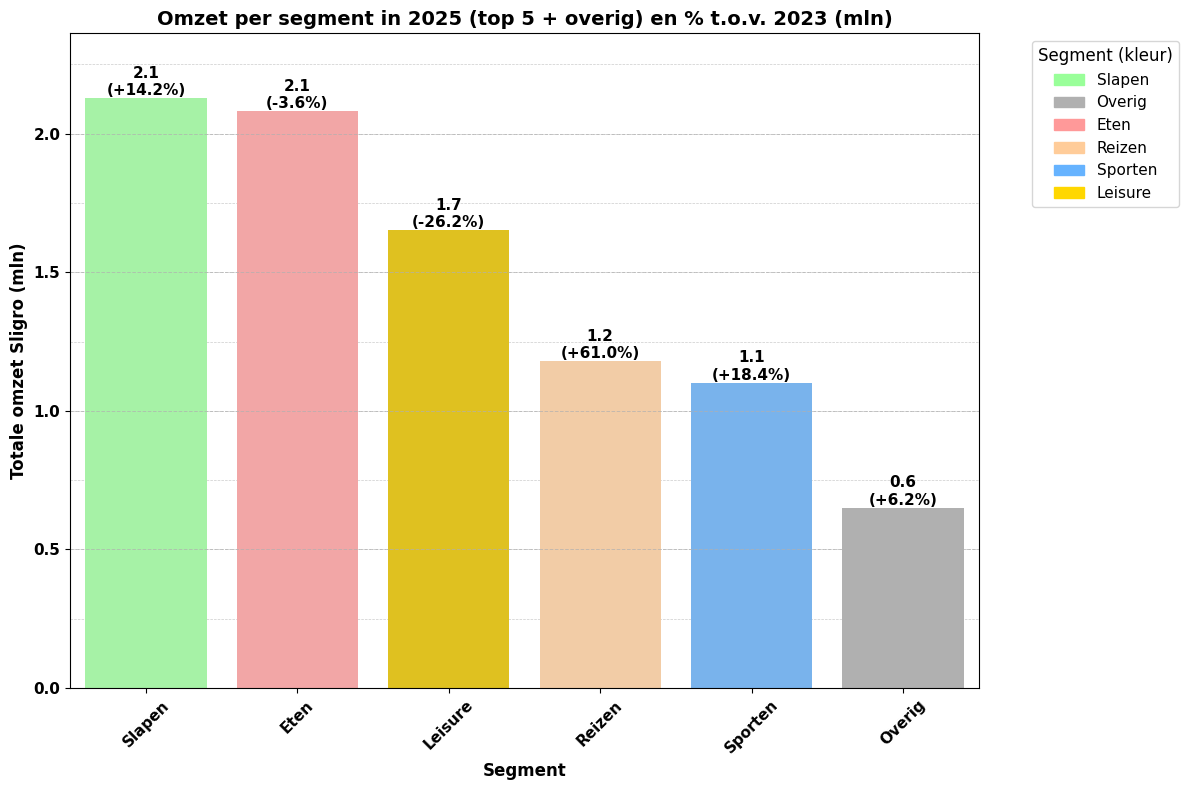

In [88]:
# 1. Omzet per segment in 2025 (top 5 + overig, kleur per segment, met legenda en % t.o.v. 2023, omzet in miljoenen)
# Data voor 2025 en 2023
jaar = 2025
segmenten_top5_2025 = df_clean[df_clean['jaar'] == jaar].groupby('Segment')['Omzet_Sligro'].sum().nlargest(5).index.tolist()
df_2025 = df_clean[df_clean['jaar'] == jaar].copy()
df_2023 = df_clean[df_clean['jaar'] == 2023].copy()
df_2025['Segment_top5'] = df_2025['Segment'].where(df_2025['Segment'].isin(segmenten_top5_2025), 'Overig')
df_2023['Segment_top5'] = df_2023['Segment'].where(df_2023['Segment'].isin(segmenten_top5_2025), 'Overig')
df_2025['Omzet_Sligro_miljoen'] = df_2025['Omzet_Sligro'] / 1_000_000
df_2023['Omzet_Sligro_miljoen'] = df_2023['Omzet_Sligro'] / 1_000_000
omzet_2025 = df_2025.groupby('Segment_top5')['Omzet_Sligro_miljoen'].sum()
omzet_2023 = df_2023.groupby('Segment_top5')['Omzet_Sligro_miljoen'].sum()
omzet_compare = pd.DataFrame({'2025': omzet_2025, '2023': omzet_2023})
omzet_compare = omzet_compare.fillna(0)
omzet_compare['perc_vs_2023'] = np.where(omzet_compare['2023'] > 0, 100 * (omzet_compare['2025'] - omzet_compare['2023']) / omzet_compare['2023'], np.nan)
omzet_compare = omzet_compare.sort_values('2025', ascending=False).reset_index()
activity_colors = {
    'Eten': '#FF9999',
    'Sporten': '#66B3FF',
    'Slapen': '#99FF99',
    'Reizen': '#FFCC99',
    'Leisure': '#FFD700',
    'Drink': '#FF69B4',
    'Leren': '#8A2BE2',
    'Evenementen': '#FF4500',
    'Cateraars': '#2E8B57',
    'Shoppen food': '#FF8C00',
    'Shoppen non food': '#1E90FF',
    'Overig': '#b0b0b0'
}
bar_colors = [activity_colors.get(seg, '#cccccc') for seg in omzet_compare['Segment_top5']]
plt.figure(figsize=(12,8))
bars = sns.barplot(data=omzet_compare, x='Segment_top5', y='2025', palette=bar_colors)
plt.title('Omzet per segment in 2025 (top 5 + overig) en % t.o.v. 2023 (mln)', fontsize=14, fontweight='bold')
plt.ylabel('Totale omzet Sligro (mln)', fontsize=12, fontweight='bold')
plt.xlabel('Segment', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
for y in plt.yticks()[0]:
    plt.axhline(y, color='grey', linestyle='--', linewidth=0.5, alpha=0.4, zorder=0)
for i, (v, p) in enumerate(zip(omzet_compare['2025'], omzet_compare['perc_vs_2023'])):
    if not np.isnan(p):
        plt.text(i, v, f'{v:,.1f}\n({p:+.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')
    else:
        plt.text(i, v, f'{v:,.1f}\n(n.v.t.)', ha='center', va='bottom', fontsize=11, fontweight='bold')
import matplotlib.patches as mpatches
used_segments = list({seg for seg in omzet_compare['Segment_top5'] if seg in activity_colors})
legend_patches = [mpatches.Patch(color=activity_colors[seg], label=seg) for seg in used_segments]
plt.legend(handles=legend_patches, title='Segment (kleur)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipykernel_19688/1842745800.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=omzet_compare, x='Segment', y='2025', palette=bar_colors)


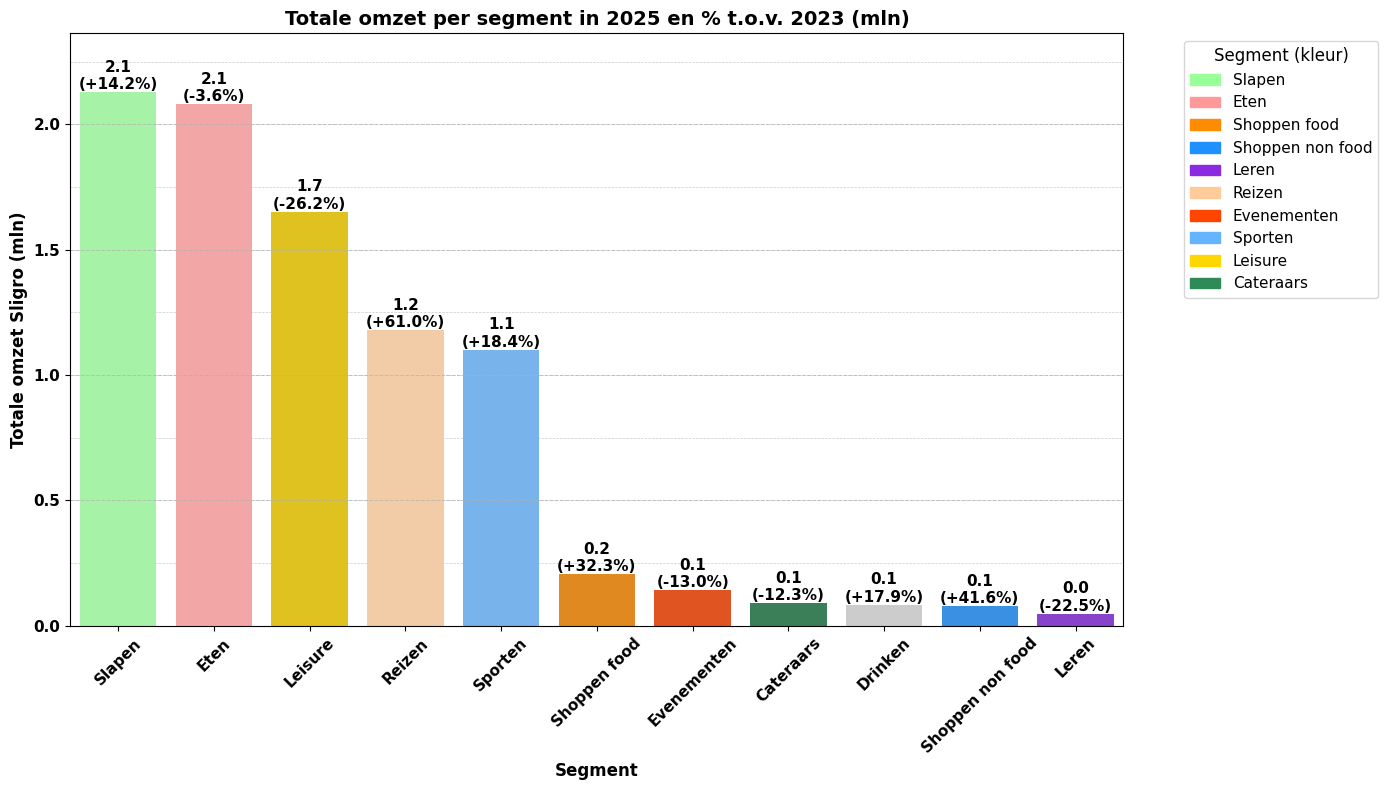

In [89]:
# 2. Omzet per segment in 2025 (alle segmenten, absolute omzet en % t.o.v. 2023, kleur per segment, met legenda, omzet in miljoenen)
omzet_2025 = df_clean[df_clean['jaar'] == 2025].groupby('Segment')['Omzet_Sligro'].sum() / 1_000_000
omzet_2023 = df_clean[df_clean['jaar'] == 2023].groupby('Segment')['Omzet_Sligro'].sum() / 1_000_000
omzet_compare = pd.DataFrame({'2025': omzet_2025, '2023': omzet_2023})
omzet_compare = omzet_compare.fillna(0)
omzet_compare['perc_vs_2023'] = np.where(omzet_compare['2023'] > 0, 100 * (omzet_compare['2025'] - omzet_compare['2023']) / omzet_compare['2023'], np.nan)
omzet_compare = omzet_compare.sort_values('2025', ascending=False).reset_index()
activity_colors = {
    'Eten': '#FF9999',
    'Sporten': '#66B3FF',
    'Slapen': '#99FF99',
    'Reizen': '#FFCC99',
    'Leisure': '#FFD700',
    'Drink': '#FF69B4',
    'Leren': '#8A2BE2',
    'Evenementen': '#FF4500',
    'Cateraars': '#2E8B57',
    'Shoppen food': '#FF8C00',
    'Shoppen non food': '#1E90FF',
    'Overig': '#b0b0b0'
}
bar_colors = [activity_colors.get(seg, '#cccccc') for seg in omzet_compare['Segment']]
plt.figure(figsize=(14,8))
bars = sns.barplot(data=omzet_compare, x='Segment', y='2025', palette=bar_colors)
plt.title('Totale omzet per segment in 2025 en % t.o.v. 2023 (mln)', fontsize=14, fontweight='bold')
plt.ylabel('Totale omzet Sligro (mln)', fontsize=12, fontweight='bold')
plt.xlabel('Segment', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
for y in plt.yticks()[0]:
    plt.axhline(y, color='grey', linestyle='--', linewidth=0.5, alpha=0.4, zorder=0)
for i, (v, p) in enumerate(zip(omzet_compare['2025'], omzet_compare['perc_vs_2023'])):
    if not np.isnan(p):
        plt.text(i, v, f'{v:,.1f}\n({p:+.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')
    else:
        plt.text(i, v, f'{v:,.1f}\n(n.v.t.)', ha='center', va='bottom', fontsize=11, fontweight='bold')
import matplotlib.patches as mpatches
used_segments = list({seg for seg in omzet_compare['Segment'] if seg in activity_colors})
legend_patches = [mpatches.Patch(color=activity_colors[seg], label=seg) for seg in used_segments]
plt.legend(handles=legend_patches, title='Segment (kleur)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipykernel_19688/3655189678.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=top10, x='Hoofdactiviteit', y='2025', palette=bar_colors)


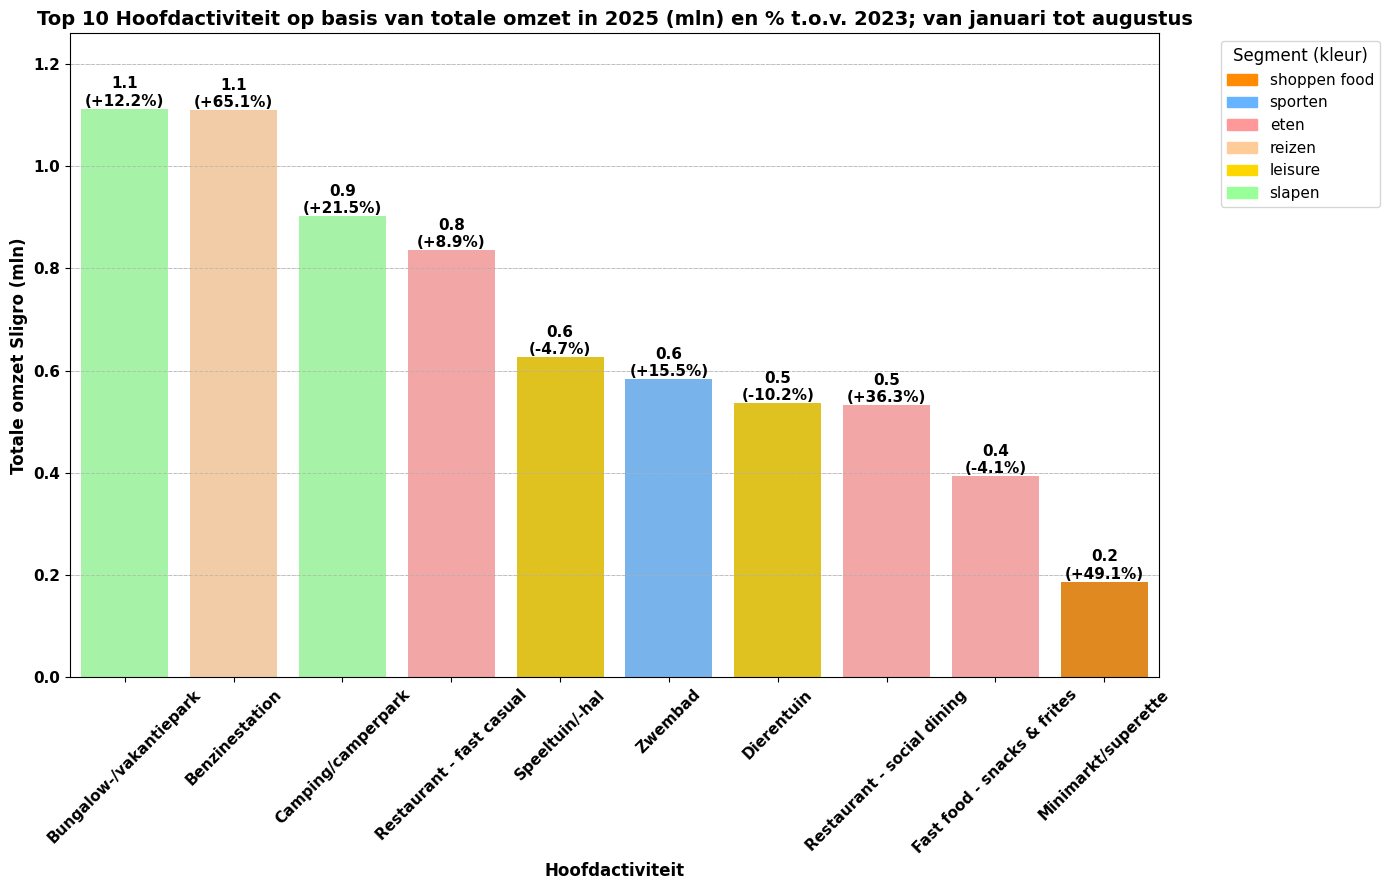

In [90]:
# 3. Top 10 Hoofdactiviteit op basis van totale omzet in 2025 (in miljoenen) en % t.o.v. 2023 (kleur per segment, met legenda)
# Data voor 2025 en 2023
omzet_2025 = df_clean[df_clean['jaar'] == 2025].groupby('Hoofdactiviteit')['Omzet_Sligro'].sum() / 1_000_000
omzet_2023 = df_clean[df_clean['jaar'] == 2023].groupby('Hoofdactiviteit')['Omzet_Sligro'].sum() / 1_000_000
omzet_compare = pd.DataFrame({'2025': omzet_2025, '2023': omzet_2023})
omzet_compare = omzet_compare.fillna(0)
omzet_compare['perc_vs_2023'] = np.where(omzet_compare['2023'] > 0, 100 * (omzet_compare['2025'] - omzet_compare['2023']) / omzet_compare['2023'], np.nan)
top10_labels = [
    'Bungalow-/vakantiepark',
    'Benzinestation',
    'Camping/camperpark',
    'Restaurant - fast casual',
    'Speeltuin/-hal',
    'Zwembad',
    'Dierentuin',
    'Restaurant - social dining',
    'Fast food - snacks & frites',
    'Minimarkt/superette'
    ]
top10 = omzet_compare.loc[top10_labels].reset_index()
# Mapping van hoofdactiviteit naar segment
segment_mapping = {
    'Bungalow-/vakantiepark': 'slapen',
    'Benzinestation': 'reizen',
    'Camping/camperpark': 'slapen',
    'Restaurant - fast casual': 'eten',
    'Speeltuin/-hal': 'leisure',
    'Zwembad': 'sporten',
    'Dierentuin': 'leisure',
    'Restaurant - social dining': 'eten',
    'Fast food - snacks & frites': 'eten',
    'Minimarkt/superette': 'shoppen food'
}
activity_colors = {
    'eten': '#FF9999',
    'sporten': '#66B3FF',
    'slapen': '#99FF99',
    'reizen': '#FFCC99',
    'leisure': '#FFD700',
    'drink': '#FF69B4',
    'leren': '#8A2BE2',
    'evenementen': '#FF4500',
    'cateraars': '#2E8B57',
    'shoppen food': '#FF8C00',
    'shoppen non food': '#1E90FF'
}
bar_segments = [segment_mapping.get(act, '') for act in top10['Hoofdactiviteit']]
bar_colors = [activity_colors.get(seg, '#cccccc') for seg in bar_segments]
plt.figure(figsize=(14,9))
bars = sns.barplot(data=top10, x='Hoofdactiviteit', y='2025', palette=bar_colors)
plt.title('Top 10 Hoofdactiviteit op basis van totale omzet in 2025 (mln) en % t.o.v. 2023; van januari tot augustus', fontsize=14, fontweight='bold')
plt.ylabel('Totale omzet Sligro (mln)', fontsize=12, fontweight='bold')
plt.xlabel('Hoofdactiviteit', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
for y in plt.yticks()[0]:
    plt.axhline(y, color='grey', linestyle='--', linewidth=0.5, alpha=0.4, zorder=0)
for i, (v, p) in enumerate(zip(top10['2025'], top10['perc_vs_2023'])):
    if not np.isnan(p):
        plt.text(i, v, f'{v:,.1f}\n({p:+.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')
    else:
        plt.text(i, v, f'{v:,.1f}\n(n.v.t.)', ha='center', va='bottom', fontsize=11, fontweight='bold')
# Legenda genereren
import matplotlib.patches as mpatches
used_segments = list({seg for seg in bar_segments if seg in activity_colors})
legend_patches = [mpatches.Patch(color=activity_colors[seg], label=seg) for seg in used_segments]
plt.legend(handles=legend_patches, title='Segment (kleur)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipykernel_19688/3197228725.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=omzet_compare, x='Brand', y='2025', palette='viridis')


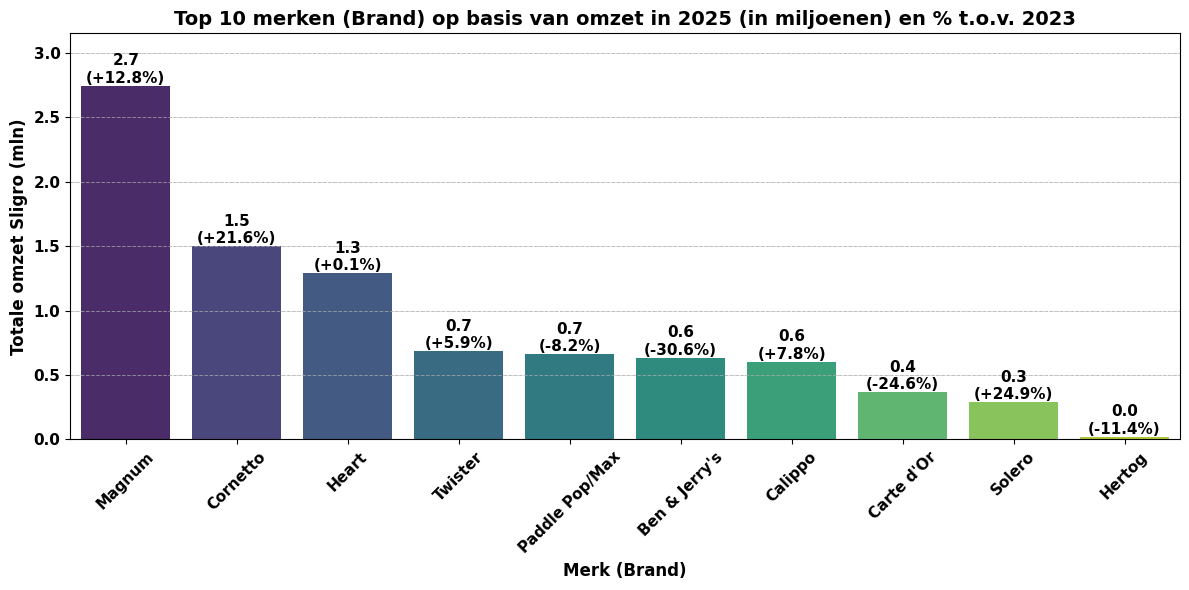

In [91]:
# 5. Omzet per merk (Brand) in 2025: Top 10 merken (omzet in miljoenen) en % t.o.v. 2023
if 'Brand' in df_clean.columns:
    omzet_2025 = df_clean[df_clean['jaar'] == 2025].groupby('Brand')['Omzet_Sligro'].sum() / 1_000_000
    omzet_2023 = df_clean[df_clean['jaar'] == 2023].groupby('Brand')['Omzet_Sligro'].sum() / 1_000_000
    omzet_compare = pd.DataFrame({'2025': omzet_2025, '2023': omzet_2023})
    omzet_compare = omzet_compare.fillna(0)
    omzet_compare['perc_vs_2023'] = np.where(omzet_compare['2023'] > 0, 100 * (omzet_compare['2025'] - omzet_compare['2023']) / omzet_compare['2023'], np.nan)
    omzet_compare = omzet_compare.sort_values('2025', ascending=False).head(10).reset_index()
    plt.figure(figsize=(12,6))
    bars = sns.barplot(data=omzet_compare, x='Brand', y='2025', palette='viridis')
    plt.title('Top 10 merken (Brand) op basis van omzet in 2025 (in miljoenen) en % t.o.v. 2023', fontsize=14, fontweight='bold')
    plt.ylabel('Totale omzet Sligro (mln)', fontsize=12, fontweight='bold')
    plt.xlabel('Merk (Brand)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, fontsize=11, fontweight='bold')
    plt.yticks(fontsize=11, fontweight='bold')
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    # Toevoegen van horizontale hulplijnen (soft lines)
    for y in plt.yticks()[0]:
        plt.axhline(y, color='grey', linestyle='--', linewidth=0.5, alpha=0.4, zorder=0)
    for i, (v, p) in enumerate(zip(omzet_compare['2025'], omzet_compare['perc_vs_2023'])):
        if not np.isnan(p):
            plt.text(i, v, f'{v:,.1f}\n({p:+.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')
        else:
            plt.text(i, v, f'{v:,.1f}\n(n.v.t.)', ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print('Brand niet gevonden in de data.')

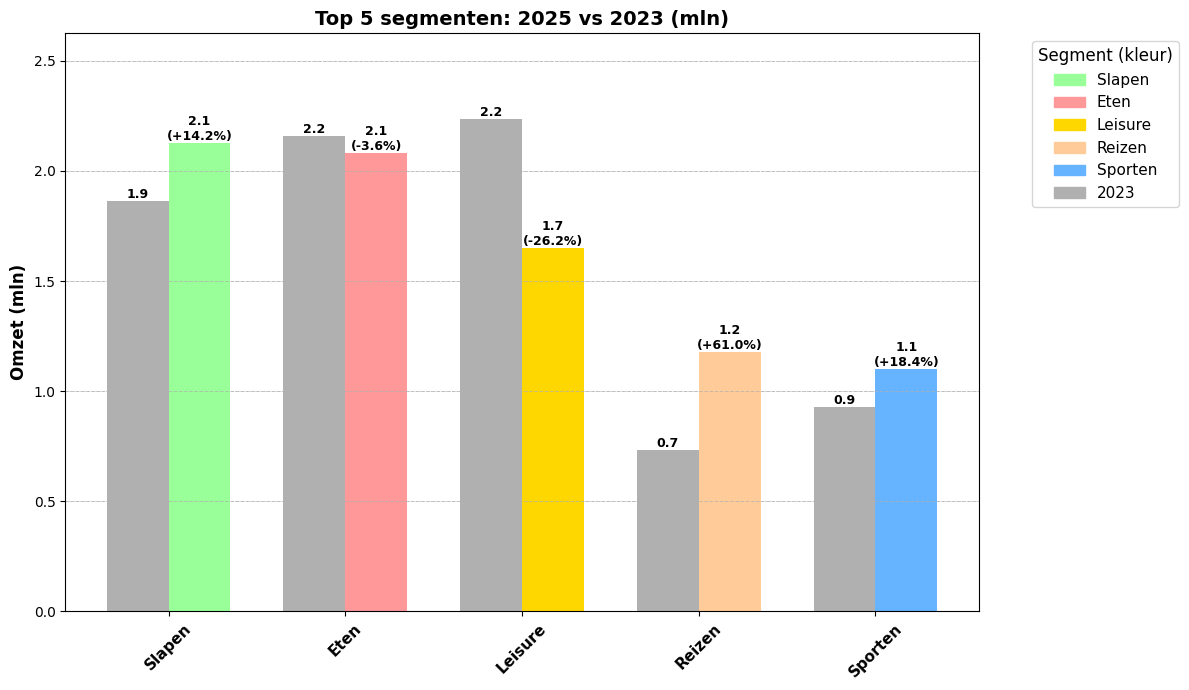

In [92]:
# 4. Top 5 segmenten: 2025 versus 2023 (side-by-side, omzet in miljoenen, gesorteerd van hoog naar laag, met hulplijnen en % verschil)
top5_2025 = df_clean[df_clean['jaar'] == 2025].groupby('Segment')['Omzet_Sligro'].sum().nlargest(5)
top5_labels = top5_2025.index.tolist()
top5_2023 = df_clean[(df_clean['jaar'] == 2023) & (df_clean['Segment'].isin(top5_labels))].groupby('Segment')['Omzet_Sligro'].sum()
top5_2025 = top5_2025 / 1_000_000
top5_2023 = top5_2023 / 1_000_000
top5_df = pd.DataFrame({'2025': top5_2025, '2023': top5_2023})
top5_df = top5_df.fillna(0)
top5_df['perc_vs_2023'] = np.where(top5_df['2023'] > 0, 100 * (top5_df['2025'] - top5_df['2023']) / top5_df['2023'], np.nan)
top5_df = top5_df.sort_values('2025', ascending=False)
activity_colors = {
    'Eten': '#FF9999',
    'Sporten': '#66B3FF',
    'Slapen': '#99FF99',
    'Reizen': '#FFCC99',
    'Leisure': '#FFD700',
    'Drink': '#FF69B4',
    'Leren': '#8A2BE2',
    'Evenementen': '#FF4500',
    'Cateraars': '#2E8B57',
    'Shoppen food': '#FF8C00',
    'Shoppen non food': '#1E90FF',
    'Overig': '#b0b0b0'
}
bar_colors = [activity_colors.get(seg, '#cccccc') for seg in top5_df.index]
plt.figure(figsize=(12,7))
bar_width = 0.35
x = np.arange(len(top5_df.index))
bars1 = plt.bar(x - bar_width/2, top5_df['2023'], width=bar_width, label='2023', color='#b0b0b0')
bars2 = plt.bar(x + bar_width/2, top5_df['2025'], width=bar_width, label='2025', color=bar_colors)
plt.xticks(x, top5_df.index, rotation=45, fontsize=11, fontweight='bold')
plt.ylabel('Omzet (mln)', fontsize=12, fontweight='bold')
plt.title('Top 5 segmenten: 2025 vs 2023 (mln)', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
# Toevoegen van horizontale hulplijnen (soft lines)
for y in plt.yticks()[0]:
    plt.axhline(y, color='grey', linestyle='--', linewidth=0.5, alpha=0.4, zorder=0)
for i, (v2023, v2025, p) in enumerate(zip(top5_df['2023'], top5_df['2025'], top5_df['perc_vs_2023'])):
    plt.text(i - bar_width/2, v2023, f'{v2023:,.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.text(i + bar_width/2, v2025, f'{v2025:,.1f}\n({p:+.1f}%)' if not np.isnan(p) else f'{v2025:,.1f}\n(n.v.t.)', ha='center', va='bottom', fontsize=9, fontweight='bold')
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=activity_colors[seg], label=seg) for seg in top5_df.index]
legend_patches.append(mpatches.Patch(color='#b0b0b0', label='2023'))
plt.legend(handles=legend_patches, title='Segment (kleur)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()